In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [2]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

# **Input Embeddings**

When we observe the Transformer architecture image above, we can see that the Embeddings represent the first step of both blocks.

The InputEmbedding class below is responsible for converting the input text into numerical vectors of d_model dimensions. To prevent that our input embeddings become extremely small, we normalize them by multiplying them by the √𝑑_𝑚𝑜𝑑𝑒𝑙

In the image below, we can see how the embeddings are created. First, we have a sentence that gets split into tokens — we will explore what tokens are later on — . Then, the token IDs — identification numbers — are transformed into the embeddings, which are high-dimensional vectors.

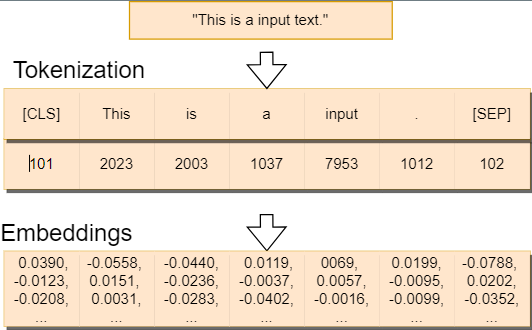

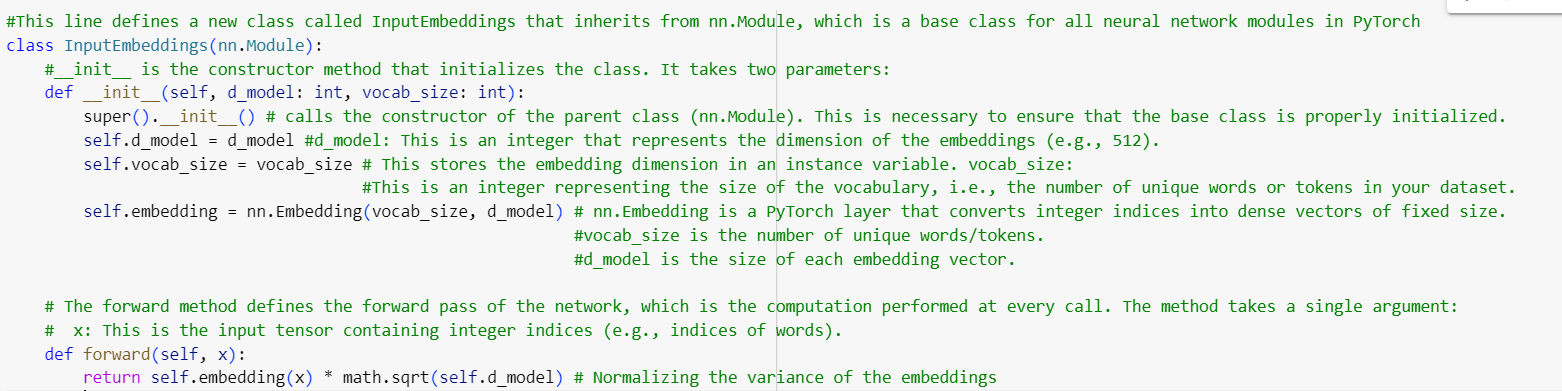

In [3]:


# This line defines a new class called InputEmbeddings that inherits from nn.Module, which is a base class for all neural network modules in PyTorch
class InputEmbeddings(nn.Module):
    # __init__ is the constructor method that initializes the class. It takes two parameters:
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()  # Calls the constructor of the parent class (nn.Module). This is necessary to ensure that the base class is properly initialized.
        self.d_model = d_model  # d_model: This is an integer that represents the dimension of the embeddings (e.g., 512).
        self.vocab_size = vocab_size  # This stores the embedding dimension in an instance variable. vocab_size: This is an integer representing the size of the vocabulary, i.e., the number of unique words or tokens in your dataset.
        self.embedding = nn.Embedding(vocab_size, d_model)  # nn.Embedding is a PyTorch layer that converts integer indices into dense vectors of fixed size. vocab_size is the number of unique words/tokens. d_model is the size of each embedding vector.

    # The forward method defines the forward pass of the network, which is the computation performed at every call. The method takes a single argument:
    # x: This is the input tensor containing integer indices (e.g., indices of words).
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)  # Normalizing the variance of the embeddings


In [4]:
# Example parameters
d_model = 512
vocab_size = 10000

# Instantiate the InputEmbeddings class
input_embeddings = InputEmbeddings(d_model, vocab_size)
# Example input (batch of token indices)
# Let's say the text "hello world" is tokenized as [1, 2,] and "goodbye world" is tokenized as [4, 5]
input_tokens = torch.LongTensor([[1, 2], [4, 5]])

# Get the embeddings
output_embeddings = input_embeddings(input_tokens)

# Print the output embeddings
print("embeddings",output_embeddings)
print("---------------------------------------------------------------")
print("embedding of first input token",output_embeddings[0])
print("length of embedding 1 embedding vector",len(output_embeddings[0][0]))

print(output_embeddings.shape)

embeddings tensor([[[-15.3953, -15.6741, -14.9728,  ...,   4.5331,  17.3247,  34.4706],
         [ 40.0451,   1.3828,  11.8896,  ..., -27.1235,  -3.8597,  -7.9864]],

        [[-20.1970,  20.9942,   5.6044,  ...,  -7.3247, -23.5010,  25.5000],
         [ 22.3439,  38.4081,   0.5446,  ...,  -2.8196,  11.0485,  -3.7285]]],
       grad_fn=<MulBackward0>)
---------------------------------------------------------------
embedding of first input token tensor([[-15.3953, -15.6741, -14.9728,  ...,   4.5331,  17.3247,  34.4706],
        [ 40.0451,   1.3828,  11.8896,  ..., -27.1235,  -3.8597,  -7.9864]],
       grad_fn=<SelectBackward0>)
length of embedding 1 embedding vector 512
torch.Size([2, 2, 512])


### Background
 RNNs/LSTMS inherently take the order of word into account; They parse a sentence word by word in a sequential manner which is why they are slow

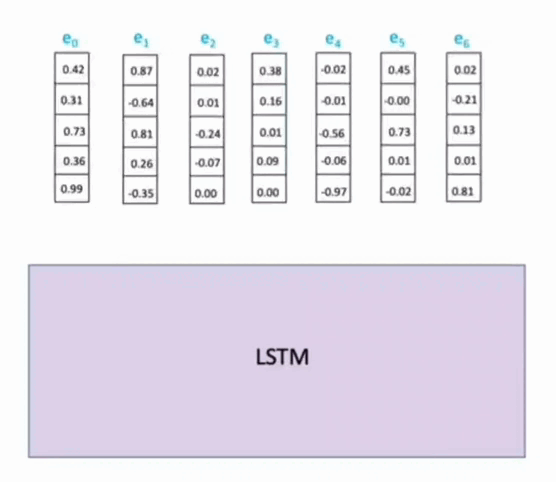

Tranformers on the other hand takes these embeddings simultaneously. But the question is:

 **How do Transformers preserve the sequential order of information within the input data?**
 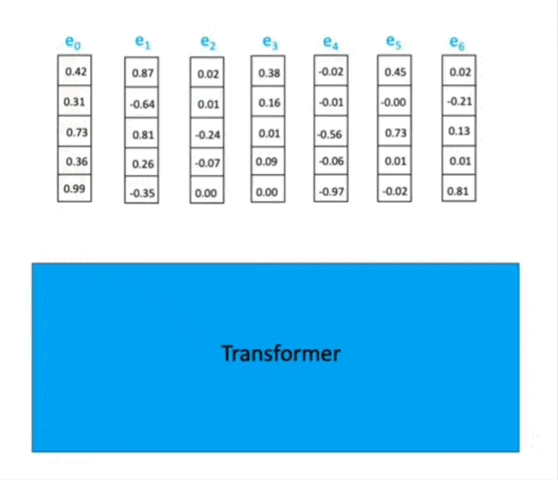

To make the transformers context aware, how about we introduce a new set of vectors containing the position information
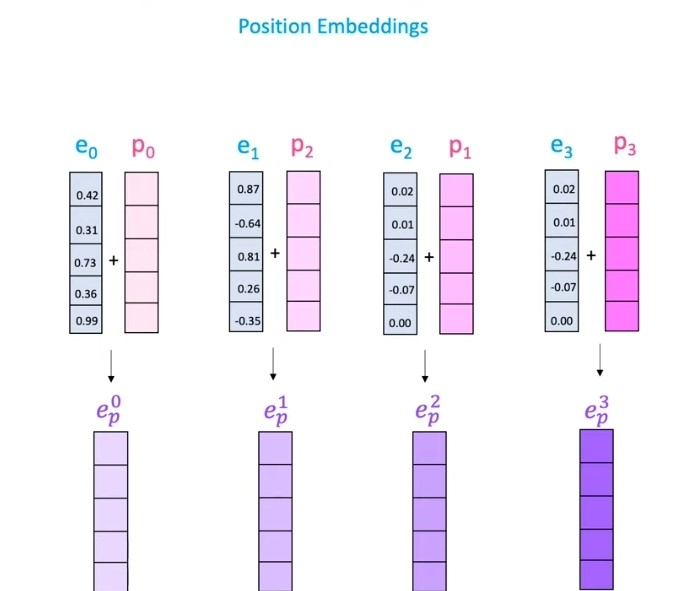

## **QUESTION!**
**What values should these position embeddings contain?**
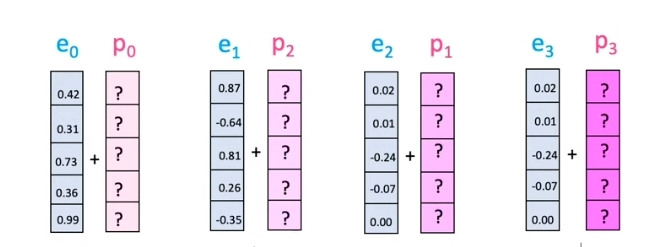

### **Solution!**
The Authors of the paper "[Attention is all you need](https://https://arxiv.org/pdf/1706.03762.pdf)" have proposed a very elegant solution for these position embeddings.

#### **Positional Encoding**: The positional encoding function in the transformers architecture introduces the concept of order or position into the input data.
The positional encoding function maps each position (or time step) in the input sequence to a vector representation. These positional embeddings are added element-wise to the input embeddings (usually word embeddings) before feeding them into the transformer model.

The most common type of positional encoding used is based on the **sine** and **cosine** functions. This method ensures that the positional embeddings have a consistent pattern, allowing the model to generalize well to longer sequences it might not have seen during training.
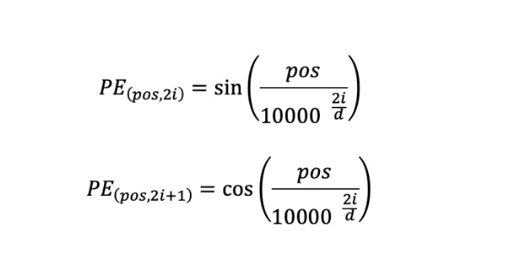

Where "pos" is the position and "i" is the dimension. "d_model" is the dimension of the embedding vector.

# **Positional Encoding**
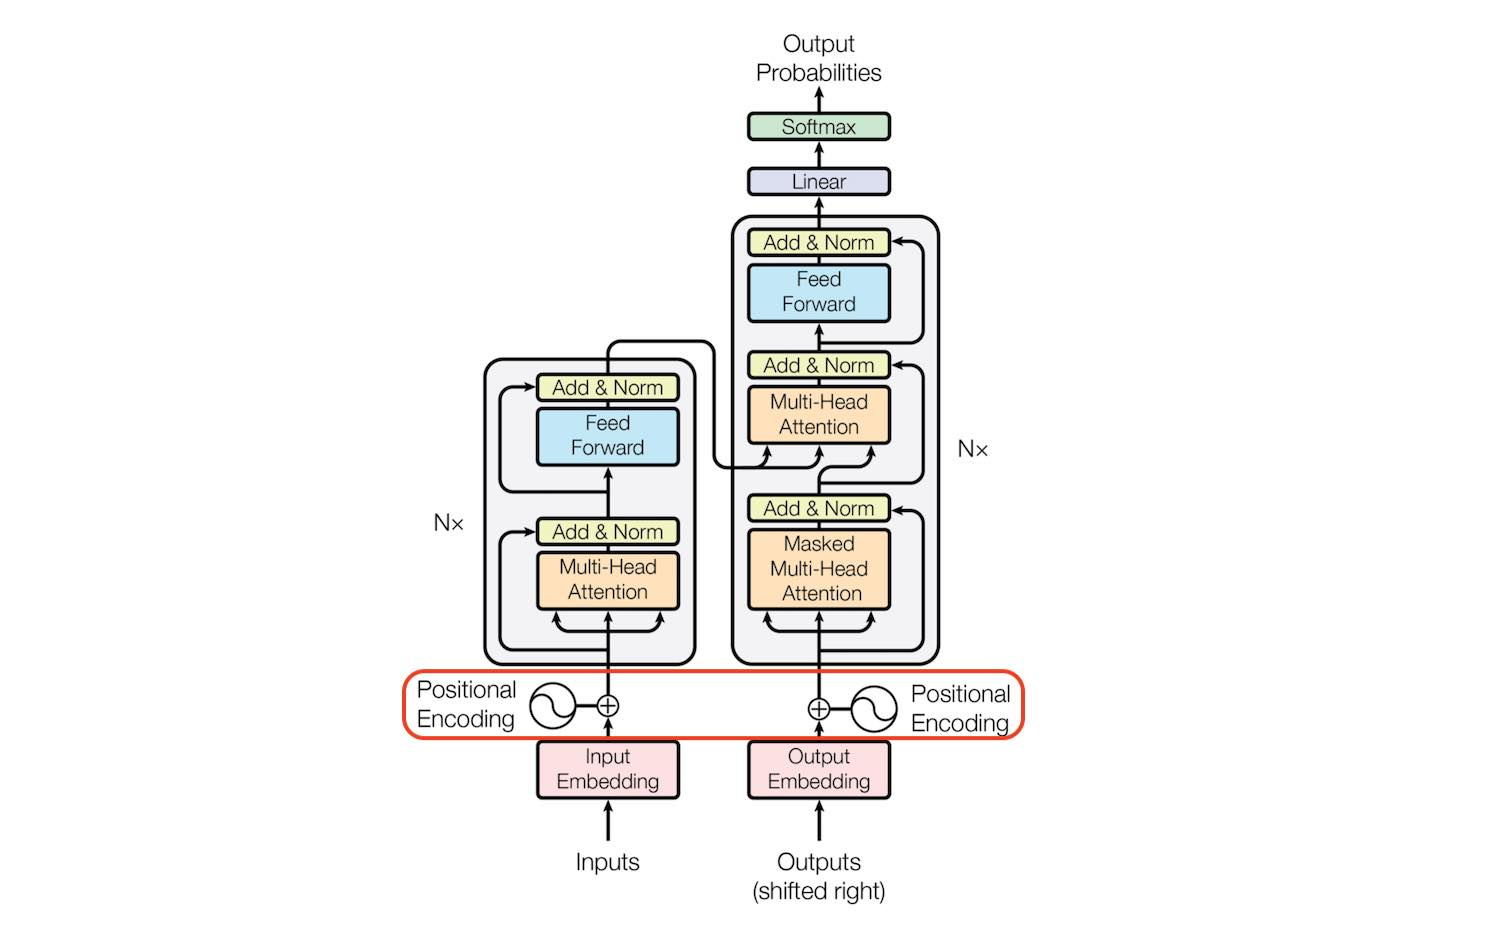

Header Photo by [Susan Yin](https://https://unsplash.com/@syinq?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://https://unsplash.com/s/photos/library?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)

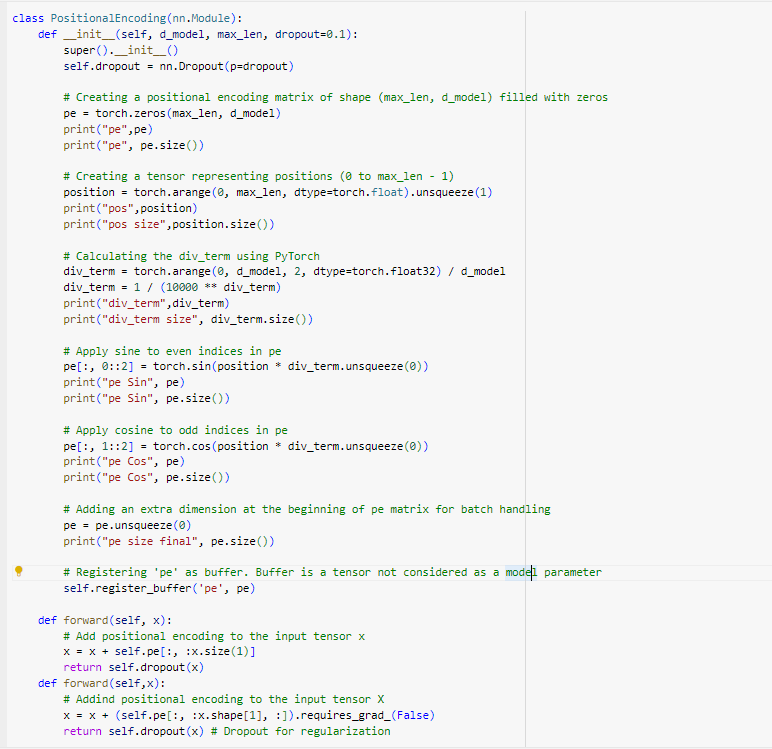

In [5]:


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Creating a positional encoding matrix of shape (max_len, d_model) filled with zeros
        pe = torch.zeros(max_len, d_model)

        # Creating a tensor representing positions (0 to max_len - 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculating the div_term using PyTorch
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)

        # Registering `pe` as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input tensor x
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# Example usage
d_model = 512
max_len = 100
dropout = 0.1
pos_encoding = PositionalEncoding(d_model, max_len, dropout)

# Create a dummy input tensor of shape (batch_size, sequence_length, d_model)
x = torch.randn(32, 100, d_model)
output = pos_encoding(x)
print(output.shape)  # Should print: torch.Size([32, 100, 512])


torch.Size([32, 100, 512])


In [6]:
# Example parameters
d_model = 6
seq_len = 3
dropout = 0.1

# Instantiate the PositionalEncoding class
pos_encoding = PositionalEncoding(d_model, seq_len, dropout)

# Example input (batch of token embeddings)
input_embeddings = torch.randn(2, 3, 6)  # batch_size=2, seq_len=3, d_model=6

# Get the positional encodings added to the input embeddings
output_embeddings = pos_encoding(input_embeddings)

# Print the input embeddings
print("Input Embeddings:\n", input_embeddings)

# Print the positional encoding
print("\nPositional Encoding:\n", pos_encoding.pe)

# Print the output embeddings
print("\nOutput Embeddings:\n", output_embeddings)

Input Embeddings:
 tensor([[[ 0.6421,  1.1547, -0.0708,  0.1711,  0.7317,  0.2371],
         [-0.6071, -1.2210,  1.3640,  1.0304,  0.5165,  0.1286],
         [-0.8357,  0.3177, -0.6980,  0.7610,  1.0547, -1.7118]],

        [[ 0.4794,  0.5792,  1.4337, -0.9285,  0.2121, -0.0294],
         [ 0.1453, -0.9812, -0.2312,  0.4890,  0.1085,  0.8887],
         [ 0.5047,  0.9016, -0.6199, -0.4383, -0.8281, -1.1151]]])

Positional Encoding:
 tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
         [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000]]])

Output Embeddings:
 tensor([[[ 0.7135,  2.3941, -0.0000,  1.3012,  0.0000,  1.3746],
         [ 0.2604, -0.7563,  1.5671,  2.2548,  0.5763,  1.2540],
         [ 0.0818, -0.0000, -0.6725,  1.9519,  1.1767, -0.7909]],

        [[ 0.5327,  1.7546,  1.5931,  0.0794,  0.2356,  1.0784],
         [ 1.0964, -0.4899, -0.2053,  0.0000,  0.1229,  2.0986],
         [ 1.5711, 

# **Layer Normalization**

When we look at the encoder and decoder blocks, we see several normalization layers called Add & Norm.

The LayerNormalization class below performs layer normalization on the input data. During its forward pass, we compute the mean and standard deviation of the input data. We then normalize the input data by subtracting the mean and dividing by the standard deviation plus a small number called epsilon to avoid any divisions by zero. This process results in a normalized output with a mean 0 and a standard deviation 1.

We will then scale the normalized output by a learnable parameter alpha and add a learnable parameter called bias. The training process is responsible for adjusting these parameters. The final result is a layer-normalized tensor, which ensures that the scale of the inputs to layers in the network is consistent.

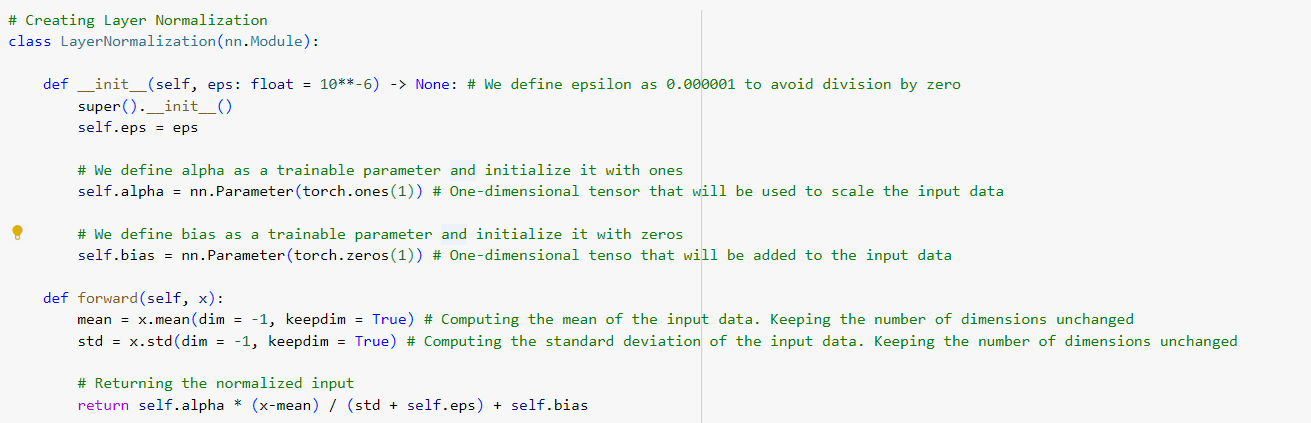

In [7]:
# Creating Layer Normalization
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 1e-6) -> None:  # We define epsilon as 0.000001 to avoid division by zero
        super().__init__()
        self.eps = eps

        # We define alpha as a trainable parameter and initialize it with ones
        self.alpha = nn.Parameter(torch.ones(1))  # One-dimensional tensor that will be used to scale the input data

        # We define bias as a trainable parameter and initialize it with zeros
        self.bias = nn.Parameter(torch.zeros(1))  # One-dimensional tensor that will be added to the input data

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)  # Computing the mean of the input data. Keeping the number of dimensions unchanged
        std = x.std(dim=-1, keepdim=True)    # Computing the standard deviation of the input data. Keeping the number of dimensions unchanged

        # Returning the normalized input
        return self.alpha * (x - mean) / (std + self.eps) + self.bias






In [8]:
# Instantiate the LayerNormalization class
layer_norm = LayerNormalization()

# Example input tensor
input_tensor = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

# Apply layer normalization
output_tensor = layer_norm(input_tensor)

print("Input Tensor:")
print(input_tensor)
print("Output Tensor:")
print(output_tensor)
print("Alpha:", layer_norm.alpha.item())
print("Bias:", layer_norm.bias.item())

# Manually adjust alpha and bias to see their impact
with torch.no_grad():
    layer_norm.alpha.fill_(2.0)
    layer_norm.bias.fill_(1.0)

output_tensor_adjusted = layer_norm(input_tensor)

print("Adjusted Output Tensor:")
print(output_tensor_adjusted)
print("Adjusted Alpha:", layer_norm.alpha.item())
print("Adjusted Bias:", layer_norm.bias.item())

Input Tensor:
tensor([[1., 2., 3.],
        [4., 5., 6.]])
Output Tensor:
tensor([[-1.0000,  0.0000,  1.0000],
        [-1.0000,  0.0000,  1.0000]], grad_fn=<AddBackward0>)
Alpha: 1.0
Bias: 0.0
Adjusted Output Tensor:
tensor([[-1.0000,  1.0000,  3.0000],
        [-1.0000,  1.0000,  3.0000]], grad_fn=<AddBackward0>)
Adjusted Alpha: 2.0
Adjusted Bias: 1.0


# **Feed-Forward Network**


<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The following paragraph is taken from the paper "Attention is all you need".


In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between.
The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality
dff = 2048.



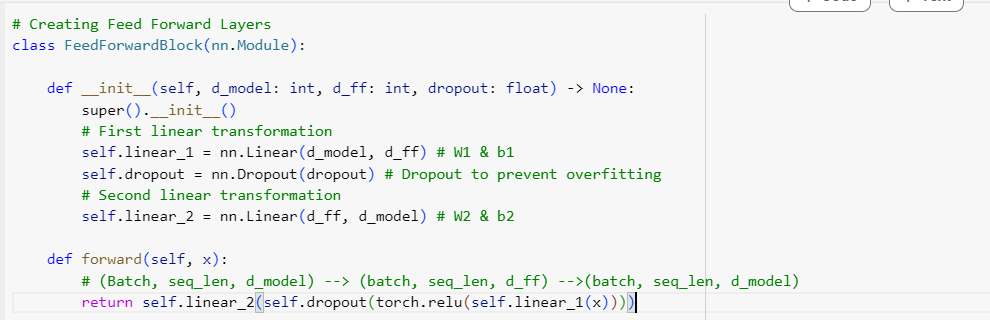

In [9]:
# Creating Feed Forward Layers
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        # First linear transformation
        self.linear_1 = nn.Linear(d_model, d_ff)  # W1 & b1
        self.dropout = nn.Dropout(dropout)        # Dropout to prevent overfitting
        # Second linear transformation
        self.linear_2 = nn.Linear(d_ff, d_model)  # W2 & b2

    def forward(self, x):
        # (Batch, seq_len, d_model) -> (batch, seq_len, d_ff) -> (batch, seq_len, d_model)
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))


In [10]:
# Example parameters
d_model = 4
d_ff = 8
dropout = 0.1

# Instantiate the FeedForwardBlock class
ff_block = FeedForwardBlock(d_model, d_ff, dropout)

# Example input tensor
input_tensor = torch.randn(2, 3, d_model)  # batch_size=2, seq_len=3, d_model=4

# Apply the feed-forward block
output_tensor = ff_block(input_tensor)

print("Input Tensor:")
print(input_tensor)
print("Output Tensor:")
print(output_tensor)

Input Tensor:
tensor([[[-0.9990, -0.9439,  0.2997, -0.1428],
         [-0.0385, -0.2574, -0.6487, -0.1709],
         [ 0.2287, -1.0473, -1.0306,  1.4905]],

        [[-0.8928, -0.0441, -0.1448,  1.0020],
         [ 0.4790,  0.0408, -0.0725, -0.1857],
         [-0.5141, -0.2096,  0.8197,  0.7671]]])
Output Tensor:
tensor([[[ 0.0463,  0.1542,  0.1973, -0.3562],
         [ 0.1561,  0.0733,  0.2101, -0.2619],
         [ 0.4296,  0.4246,  0.5058, -0.3355]],

        [[ 0.2561, -0.0697,  0.1791, -0.2070],
         [ 0.1486,  0.0923,  0.1314, -0.3698],
         [ 0.1980,  0.0817,  0.1066, -0.3651]]], grad_fn=<ViewBackward0>)


# **Multi-Head Attention**

<table>
<tr>
  <th colspan=1></th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Multi-Head Attention is the most crucial component of the Transformer. It allows the model to focus on different parts of the input sequence simultaneously, learning multiple representations.

The Multi-Head Attention block receives the input data split into queries, keys, and values organized into matrices 𝑄, 𝐾, and 𝑉. Each matrix contains different facets of the input, and they have the same dimensions as the input.

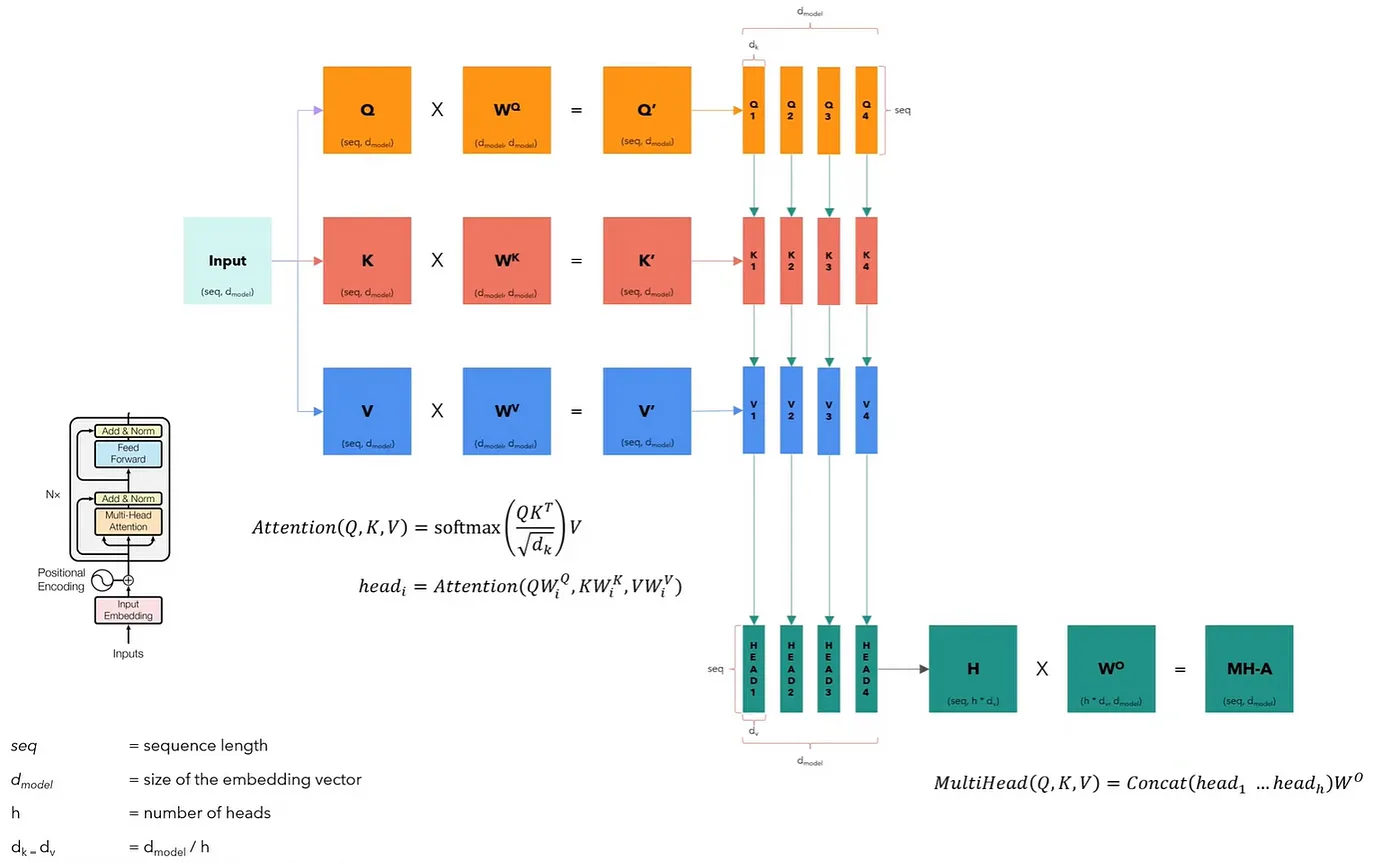

Lets code our multihead attention step by step.

We will start by creating a class MultiHeadAttentionBlock, and initialize the highlighted variables.

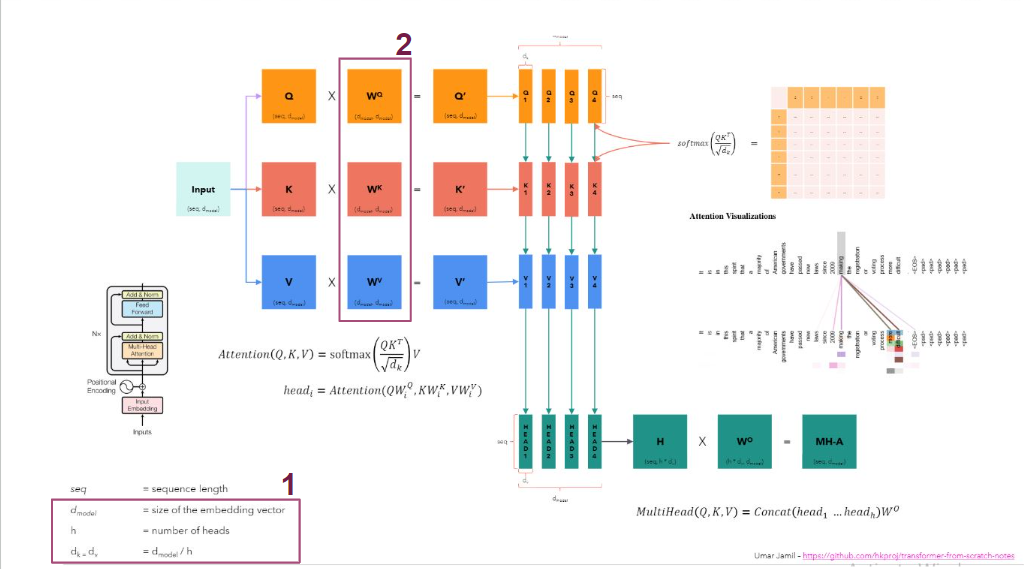

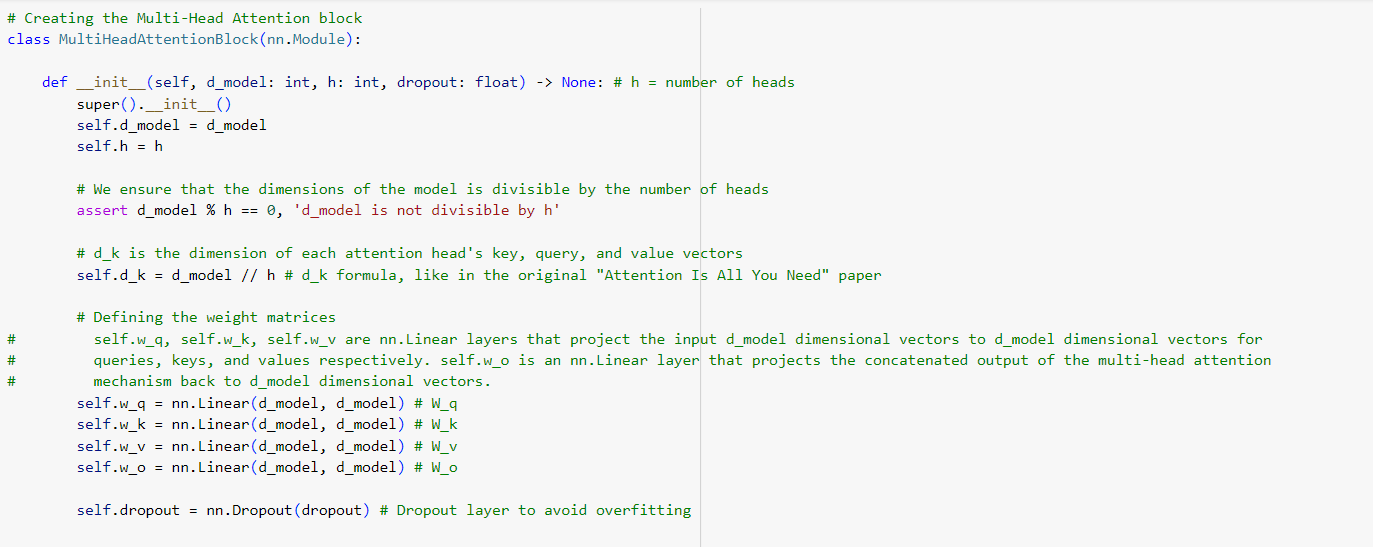

1.   We will create our forward function, which will first multiply the weights of Q, K, and V with their respective weights [1] and shape (batch_size, seq_len,d_model) .

2. In the next step, we will split these matrices into **h** heads and shape (batch_size, heads ,seq_len, d_k) [2].

3. Now, write a function to calculate attention score [3]. Don't forget the masking part.

4. Concatenate all heads to obtain H matrix, and muliply it with w_o matrix to get the multi-head attention matrix [4].

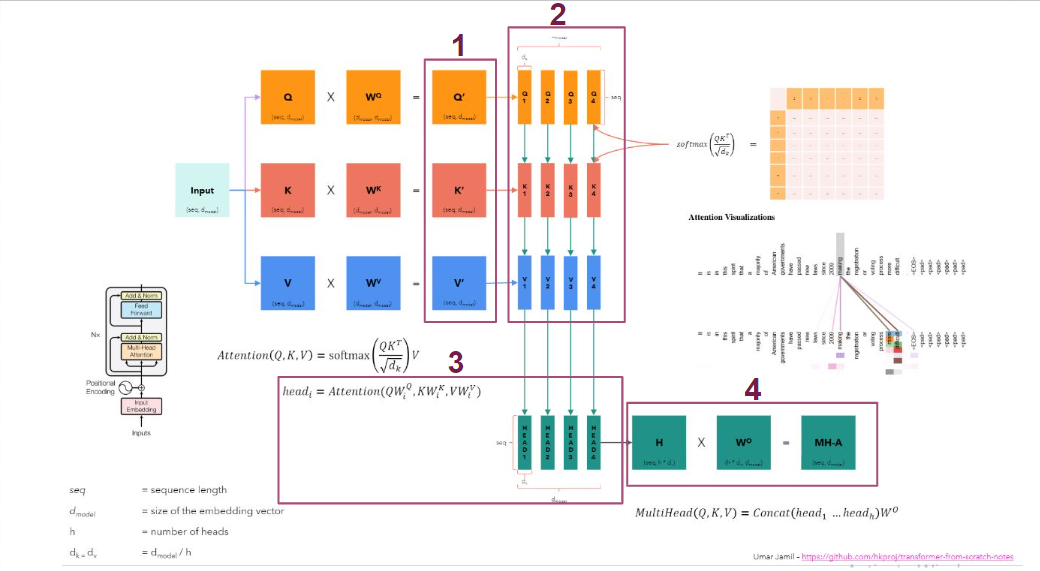

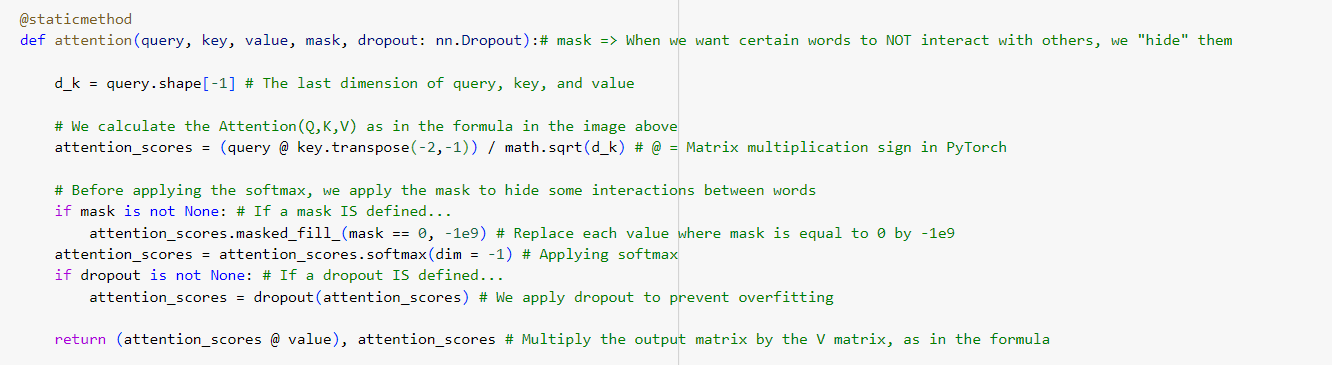

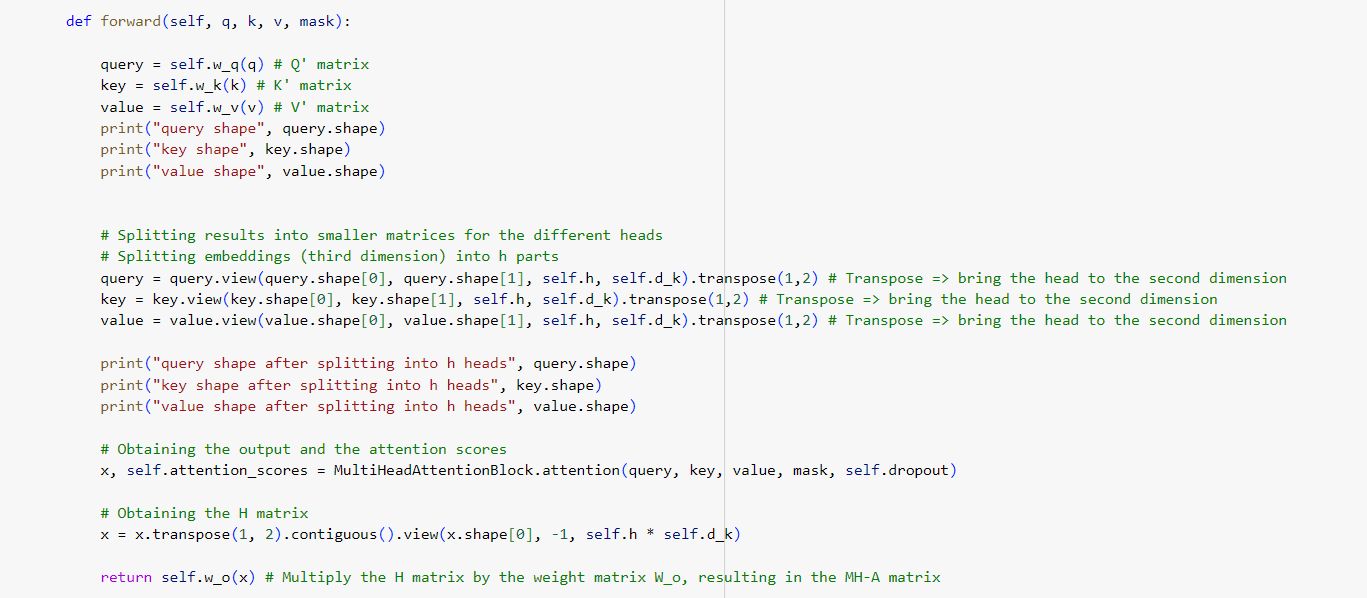

In [11]:

class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:  # h = number of heads
        super().__init__()
        self.d_model = d_model
        self.h = h

        # Ensure that d_model is divisible by h
        assert d_model % h == 0, 'd_model is not divisible by h'

        # d_k is the dimension of each attention head's key, query, and value vectors
        self.d_k = d_model // h  # d_k formula, as in the original "Attention Is All You Need" paper

        # Define the weight matrices
        self.w_q = nn.Linear(d_model, d_model)  # W_q
        self.w_k = nn.Linear(d_model, d_model)  # W_k
        self.w_v = nn.Linear(d_model, d_model)  # W_v
        self.w_o = nn.Linear(d_model, d_model)  # W_o

        self.dropout = nn.Dropout(dropout)  # Dropout layer to avoid overfitting

    @staticmethod
    def sttention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]  # The last dimension of query, key, and value

        # Calculate the Attention(Q,K,V) as in the formula in the image above
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # @ = Matrix multiplication sign in PyTorch

        # Before applying the softmax, apply the mask to hide some interactions between words
        if mask is not None:  # If a mask IS defined...
            attention_scores.masked_fill_(mask == 0, -1e9)  # Replace each value where mask is equal to 0 by -1e9

        attention_scores = nn.functional.softmax(attention_scores, dim=-1)  # Applying softmax

        # If dropout IS defined, apply dropout to prevent overfitting
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        # Multiply the output matrix by the V matrix, as in the formula
        return torch.matmul(attention_scores, value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q)  # Q matrix
        key = self.w_k(k)    # K matrix
        value = self.w_v(v)  # V matrix

        print("query shape", query.shape)
        print("key shape", key.shape)
        print("value shape", value.shape)

        # Splitting embeddings (third dimension) into h parts
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)  # Transpose to bring the head to the second dimension
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)          # Transpose to bring the head to the second dimension
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)  # Transpose to bring the head to the second dimension

        print("query shape after splitting into h heads", query.shape)
        print("key shape after splitting into h heads", key.shape)
        print("value shape after splitting into h heads", value.shape)

        # Obtain the output and the attention scores
        x, attention_scores = self.sttention(query, key, value, mask, self.dropout)

        # Obtain the H matrix
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x)  # Multiply the H matrix by the weight matrix W_o, resulting in the MHA matrix


In [12]:
# Example instantiation
d_model = 512  # Dimension of the model
h = 8         # Number of attention heads
dropout = 0.1 # Dropout rate

mh_attention = MultiHeadAttentionBlock(d_model, h, dropout)
# Example input values
batch_size = 2  # Number of sequences in a batch
seq_len = 10    # Length of each sequence
d_model = 512   # Dimension of the model

# Random tensor inputs for queries (q), keys (k), and values (v)
q = torch.rand(batch_size, seq_len, d_model)
k = torch.rand(batch_size, seq_len, d_model)
v = torch.rand(batch_size, seq_len, d_model)

# Mask (optional, None in this example)
mask = None

# Forward pass
output = mh_attention(q, k, v, mask)

print("Output shape:", output.shape)
print("Output:", output)


query shape torch.Size([2, 10, 512])
key shape torch.Size([2, 10, 512])
value shape torch.Size([2, 10, 512])
query shape after splitting into h heads torch.Size([2, 8, 10, 64])
key shape after splitting into h heads torch.Size([2, 8, 10, 64])
value shape after splitting into h heads torch.Size([2, 8, 10, 64])
Output shape: torch.Size([2, 10, 512])
Output: tensor([[[-0.0551, -0.0681, -0.1483,  ...,  0.0605, -0.1922, -0.0567],
         [-0.0597, -0.0903, -0.1659,  ...,  0.0822, -0.1789, -0.0364],
         [-0.0370, -0.0343, -0.1644,  ...,  0.0290, -0.1663, -0.0851],
         ...,
         [-0.0403, -0.0736, -0.1208,  ...,  0.0568, -0.1367, -0.0756],
         [-0.0499, -0.0782, -0.1639,  ...,  0.0476, -0.1803, -0.0637],
         [-0.0421, -0.0486, -0.1459,  ...,  0.0207, -0.1486, -0.0828]],

        [[-0.0281, -0.1301, -0.1868,  ..., -0.0325, -0.1839, -0.0585],
         [-0.0035, -0.1292, -0.2174,  ..., -0.0155, -0.1778, -0.0424],
         [-0.0437, -0.0888, -0.1764,  ..., -0.0252, -0.167

# **Residual Connection**
When we look at the architecture of the Transformer, we see that each sub-layer, including the self-attention and Feed Forward blocks, adds its output to its input before passing it to the Add & Norm layer. This approach integrates the output with the original input in the Add & Norm layer. This process is known as the skip connection, which allows the Transformer to train deep networks more effectively by providing a shortcut for the gradient to flow through during backpropagation.

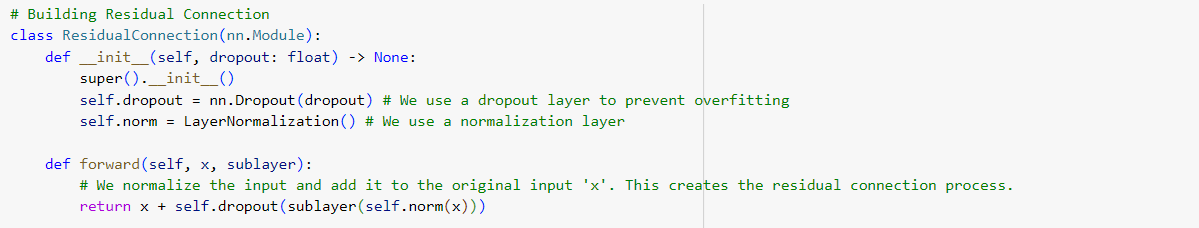

In [13]:
# Building Residual Connection
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        #Write code
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()


    def forward(self, x, sublayer):

        #Write code
        return x + self.dropout(sublayer(self.norm(x)))

In [14]:
# Example usage
dropout_rate = 0.1
residual_connection = ResidualConnection(dropout_rate)

# Example input tensor
batch_size = 2
seq_len = 3
d_model = 4
x = torch.randn(batch_size, seq_len, d_model)

# Dummy sub-layer (linear transformation for demonstration)
sublayer = nn.Linear(d_model, d_model)

# Forward pass through ResidualConnection
output = residual_connection(x, sublayer)

# Print the output
print("Input:")
print(x)
print("Output:")
print(output)

Input:
tensor([[[-2.1507,  0.1237, -0.8233, -0.4416],
         [ 0.9149, -1.1712, -0.2647, -0.4308],
         [ 0.3535, -0.5080, -0.2953,  0.4856]],

        [[ 0.0777,  0.3418, -0.3845, -2.1610],
         [-2.1464,  0.7058, -1.0261,  1.6077],
         [ 1.2571, -0.9993, -0.3995, -1.4461]]])
Output:
tensor([[[-2.3194,  0.7298, -0.0479, -0.6769],
         [ 0.8244, -2.5089, -0.2286, -0.5665],
         [-0.2703, -2.1420,  0.3394, -0.3873]],

        [[ 0.4580,  0.4581, -0.3641, -1.2864],
         [-2.6826,  0.6222,  0.0138,  0.8949],
         [ 1.3848, -1.9800, -0.4670, -1.0926]]], grad_fn=<AddBackward0>)


# **Encoder**

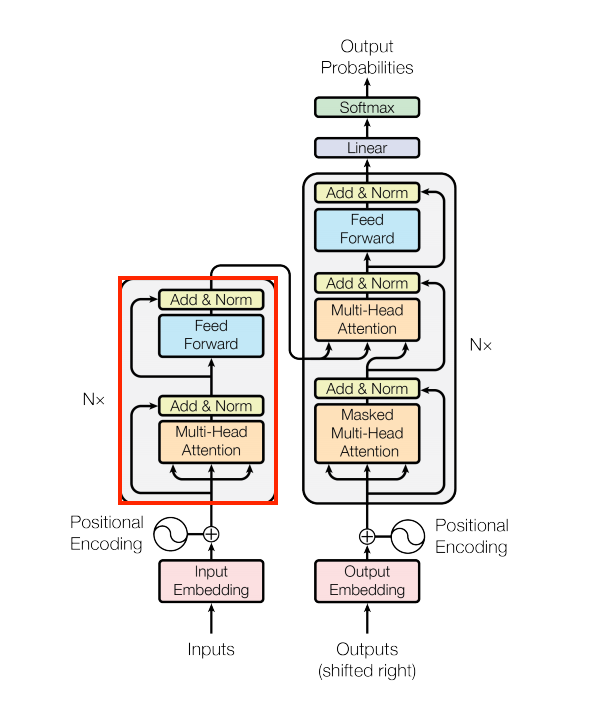

We will now build the encoder.
We create the EncoderBlock class, consisting of the Multi-Head Attention and Feed Forward layers, plus the residual connections.

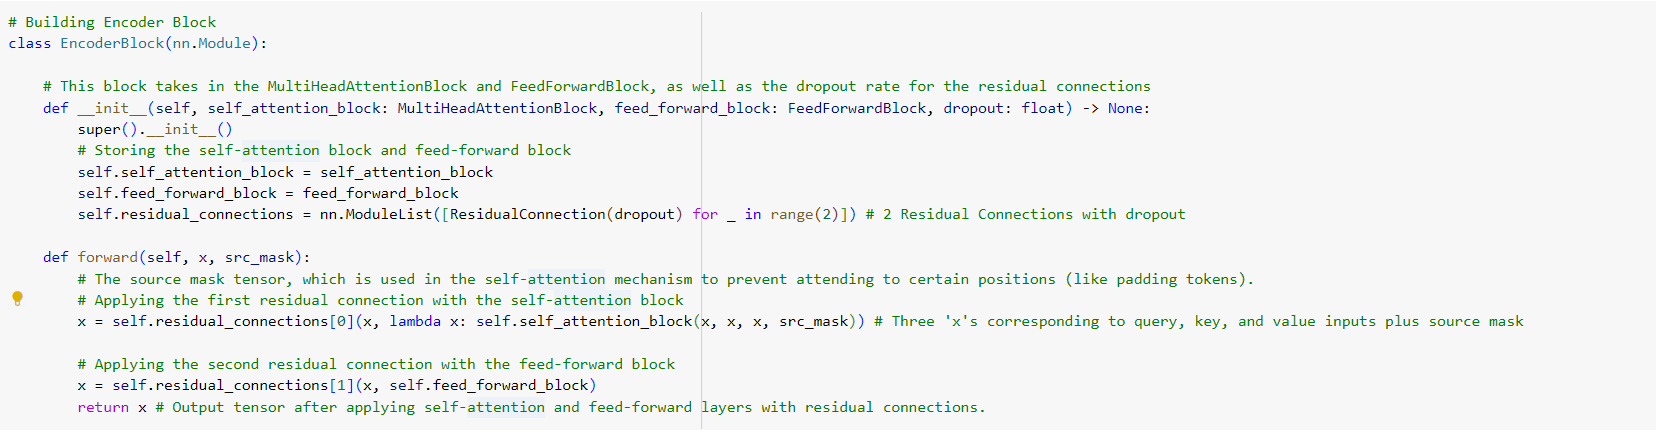

In [15]:
# Building Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention block and feed-forward block
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections with dropout

    def forward(self, x, src_mask):
        # The source mask tensor, which is used in the self-attention mechanism to prevent attending to certain positions (like padding tokens).
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three 'x's corresponding to query, key, and value inputs plus source mask

        # Applying the second residual connection with the feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention and feed-forward layers with residual connections.


Now We create the Encoder class as an assembly of multiple EncoderBlocks. We also add layer normalization as a final step after processing the input through all its blocks.

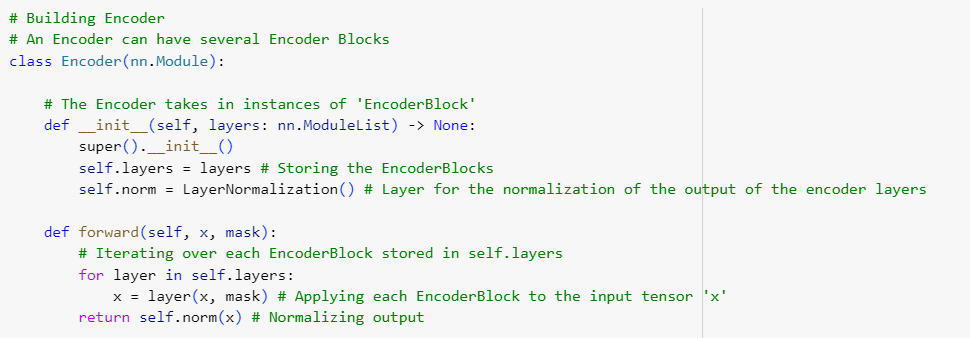

In [16]:
# Building Encoder
# An Encoder can have several Encoder Blocks
class Encoder(nn.Module):
    # The Encoder takes in instances of 'EncoderBlock'
    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers  # Storing the EncoderBlocks
        self.norm = LayerNormalization()  # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask)  # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x)  # Normalizing output


# **Decoder**
Similarly, the Decoder also consists of several DecoderBlocks that repeat six times in the original paper. The main difference is that it has an additional sub-layer that performs multi-head attention with a cross-attention component that uses the output of the Encoder as its keys and values while using the Decoder’s input as queries.

<table>
<tr>
  <th colspan=1></th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

## **Task**
Considering the architecture of decoder model, build the Decoder Block and Decoder.

Time Alloted: 7 minutes

Note: For the Output Embedding, we can use the same InputEmbeddings class we use for the Encoder. You can also notice that the self-attention sub-layer is masked, which restricts the model from accessing future elements in the sequence.

In [17]:
# Building Decoder Block
class DecoderBlock(nn.Module):
    # The DecoderBlock takes in two MultiHeadAttentionBlock instances. One is self-attention, while the other is cross-attention.
    # It also takes in the feed-forward block and the dropout rate.
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        # Storing the self-attention, cross-attention, and feed-forward blocks
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        # Creating residual connections with dropout for each block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # 3 Residual Connections with dropout

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # The target mask tensor, which is used in the self-attention mechanism to prevent attending to certain positions (like padding tokens).
        # Applying the first residual connection with the self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask)) # Three 'x's corresponding to query, key, and value inputs plus target mask

        # Applying the second residual connection with the cross-attention block
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, enc_output, enc_output, src_mask)) # 'x' for query, 'enc_output' for key and value, plus source mask

        # Applying the third residual connection with the feed-forward block
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x # Output tensor after applying self-attention, cross-attention, and feed-forward layers with residual connections.


In [18]:
# Building Decoder
# A Decoder can have several Decoder Blocks
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList, norm: LayerNormalization) -> None:
        super().__init__()
        self.layers = layers  # Storing the DecoderBlocks
        self.norm = norm  # Layer for the normalization of the output of the decoder layers

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Iterating over each DecoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)  # Applying each DecoderBlock to the input tensor 'x'
        return self.norm(x)  # Normalizing output


You can see in the Decoder image that after running a stack of DecoderBlocks, we have a Linear Layer and a Softmax function to the output of probabilities. The **ProjectionLayer** class below is responsible for converting the output of the model into a probability distribution over the vocabulary, where we select each output token from a vocabulary of possible tokens.

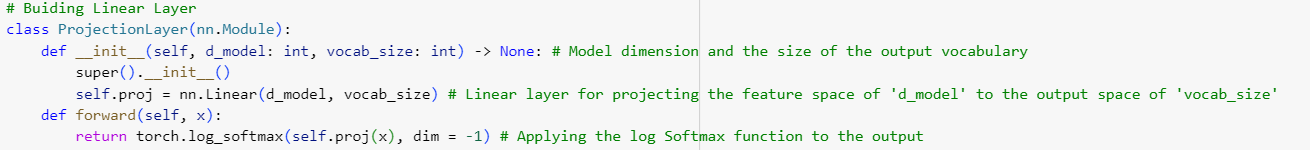

In [19]:
# Building Linear Layer
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:  # Model dimension and the size of the output vocabulary
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)  # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)  # Applying the log Softmax function to the output


# **Building the Transformer**
We finally have every component of the Transformer architecture ready. We may now construct the Transformer by putting it all together.

In the Transformer class below, we will bring together all the components of the model's architecture.

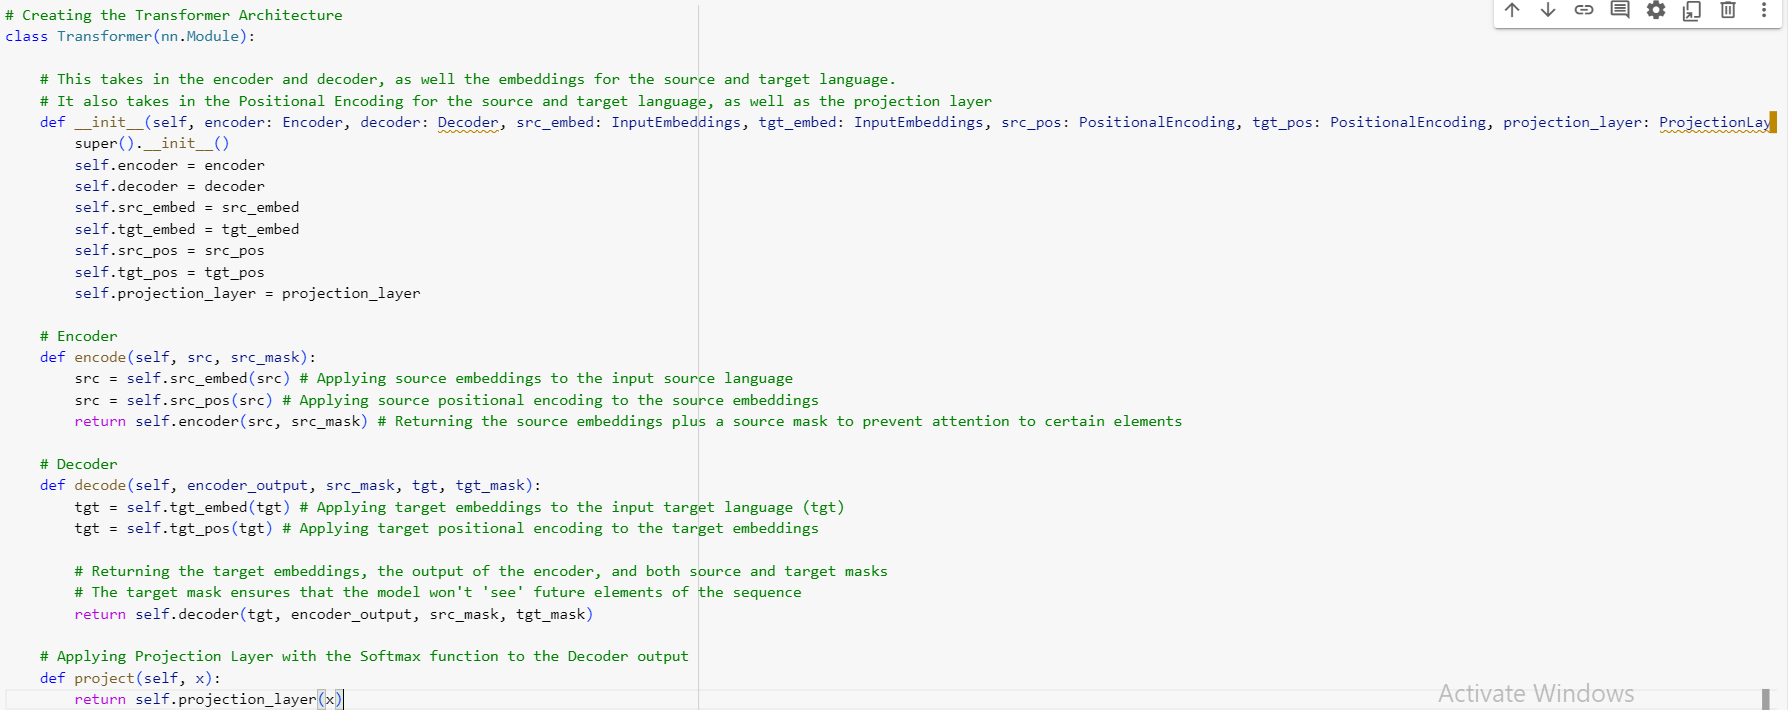

In [20]:
# Building Transformer Architecture
class Transformer(nn.Module):
    # This takes in the encoder and decoder, as well as the embeddings for the source and target languages
    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: nn.Embedding, tgt_embed: nn.Embedding,
                 src_pos: nn.Module, tgt_pos: nn.Module, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)  # Applying source embeddings to the input source language
        src = self.src_pos(src)  # Applying source positional encoding to the source embeddings
        return self.encoder(src, src_mask)  # Returning the source embeddings plus a source mask to prevent attention to certain elements

    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        tgt = self.tgt_embed(tgt)  # Applying target embeddings to the input target language (tgt)
        tgt = self.tgt_pos(tgt)  # Applying target positional encoding to the target embeddings
        return self.decoder(tgt, enc_output, src_mask, tgt_mask)  # Decoding with the target, encoder output, source mask, and target mask

    def project(self, x):
        return self.projection_layer(x)  # Applying Projection Layer with the Softmax function to the Decoder output


The architecture is finally ready. We now define a function called build_transformer, in which we define the parameters and everything we need to have a fully operational Transformer model for the task of machine translation.

We will set the same parameters as in the original paper, [Attention Is All You Need](https://arxiv.org/pdf/1706.03762), where 𝑑_𝑚𝑜𝑑𝑒𝑙 = 512, 𝑁 = 6, ℎ = 8, dropout rate 𝑃_𝑑𝑟𝑜𝑝 = 0.1, and 𝑑_𝑓𝑓= 2048.

**Task**: Write decoder blocks by yourself


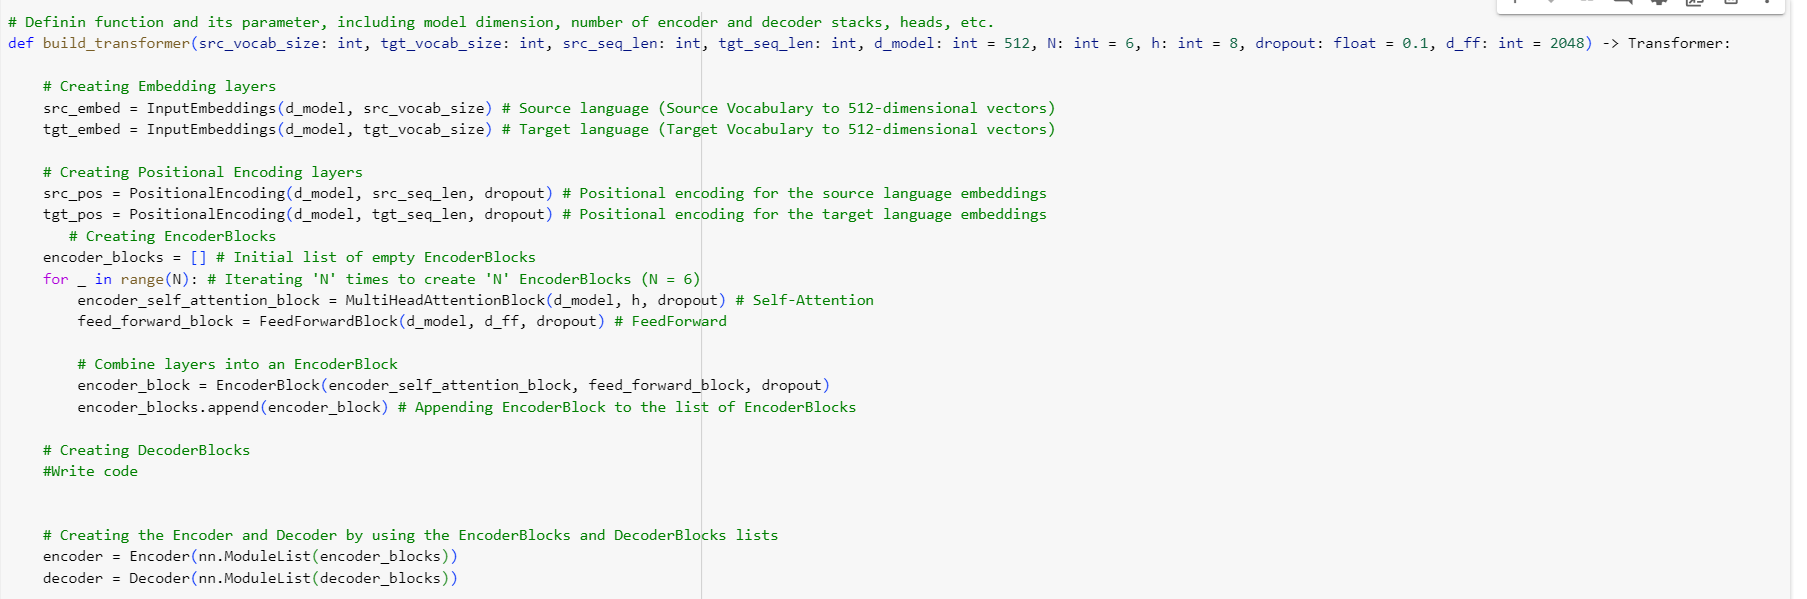

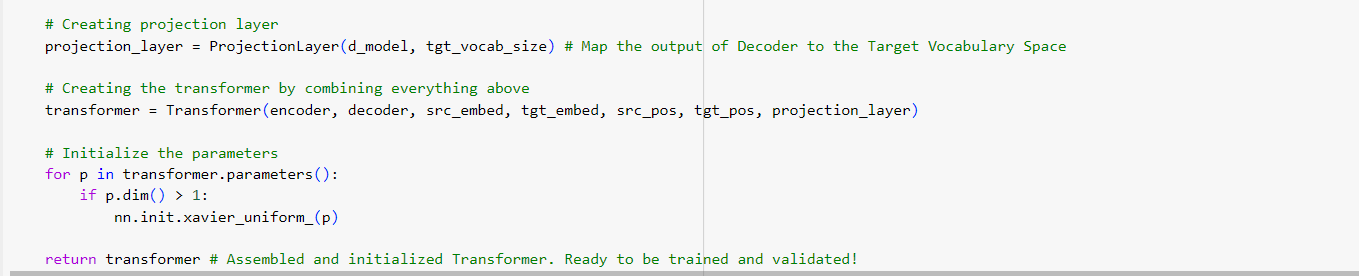

In [21]:
# Building & Initializing Transformer

# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks

    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))

    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

The model is now ready to be trained!

**Welldone!**

**You did it..** 🏅

# **Tokenizer**
Tokenization is a crucial preprocessing step for our Transformer model. In this step, we convert raw text into a number format that the model can process.
We will use the word-level tokenization to transform each word in a sentence into a token.

In the build_tokenizer function below, we ensure a tokenizer is ready to train the model. It checks if there is an existing tokenizer, and if that is not the case, it trains a new tokenizer.

In [22]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

# **Loading Dataset**
For this task, we will use the [OpusBooks dataset](https://huggingface.co/datasets/Helsinki-NLP/opus_books), available on 🤗Hugging Face. This dataset consists of two features, id and translation. The translation feature contains pairs of sentences in different languages, such as Spanish and Portuguese, English and French, and so forth.

We start by defining the get_all_sentences function to iterate over the dataset and extract the sentences according to the language pair defined—we will do that later.

In [23]:
# Iterating through dataset to extract the original sentence and its translation
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

The get_ds function is defined to load and prepare the dataset for training and validation. In this function, we build or load the tokenizer, split the dataset, and create DataLoaders, so the model can successfully iterate over the dataset in batches. The result of these functions is tokenizers for the source and target languages plus the DataLoader objects.

In [24]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers


In [25]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])


We define the **casual_mask** function to create a mask for the attention mechanism of the decoder. This mask prevents the model from having information about future elements in the sequence.

We start by making a square grid filled with ones. We determine the grid size with the size parameter. Then, we change all the numbers above the main diagonal line to zeros. Every number on one side becomes a zero, while the rest remain ones. The function then flips all these values, turning ones into zeros and zeros into ones. This process is crucial for models that predict future tokens in a sequence.

In [26]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

The BilingualDataset class processes the texts of the target and source languages in the dataset by tokenizing them and adding all the necessary special tokens. This class also certifies that the sentences are within a maximum sequence length for both languages and pads all necessary sentences.

In [27]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)


    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')

        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )

        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }

# **Validation Loop**
We will now create two functions for the validation loop. The validation loop is crucial to evaluate model performance in translating sentences from data it has not seen during training.

We will define two functions. The first function, greedy_decode, gives us the model's output by obtaining the most probable next token. The second function, run_validation, is responsible for running the validation process in which we decode the model's output and compare it with the reference text for the target sentence.

In [28]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)

        # This line of code constructs the decoder_input tensor iteratively during decoding.
        # It appends the newly predicted token (next_word.item()) to the existing decoder_input tensor.
        # This process continues until the decoding loop finishes (either reaching max_len or encountering an [EOS] token).
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [29]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

# **Training Loop**
We are ready to train our Transformer model on the OpusBook dataset for the English to Italian translation task.

We first start by defining the get_model function to load the model by calling the build_transformer function we have previously defined. This function uses the config dictionary to set a few parameters.

In [30]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

In [31]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 8,
        'num_epochs': 20,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }

# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

We finally define our last function, train_model, which takes the config arguments as input.

In this function, we will set everything up for the training. We will load the model and its necessary components onto the GPU for faster training, set the Adam optimizer, and configure the CrossEntropyLoss function to compute the differences between the translations output by the model and the reference translations from the dataset.

Every loop necessary for iterating over the training batches, performing backpropagation, and computing the gradients is in this function. We will also use it to run the validation function and save the current state of the model.

In [32]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])

    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)

    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    # Initializing training loop

    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):

        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')

        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # Performing backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count

        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)

In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

# **TASK**
Currently, greedy search decoding is implemented while validation/inferencing. Include beam search and write a report on the outcome analysis. In addition, change the hyperparameters i.e heads, encoder-decoder layers and write an analysis of the results.

# **References**

https://ai.plainenglish.io/building-and-training-a-transformer-from-scratch-fdbf3db00df4

https://youtu.be/ISNdQcPhsts?si=t1vvf2jqoh3LGNav
https://e2eml.school/transformers.html
https://medium.com/@jessica_lopez/understanding-greedy-search-and-beam-search-98c1e3cd821d
https://arxiv.org/abs/1706.03762